In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


(array([ 158.,    0.,  102.,    0.,  280.,    0.,  546.,    0.,  597.,
           0., 1522.,    0.,  993.,    0., 1755.,    0., 1557.,    0.,
         443.,  194.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 20 Patch objects>)

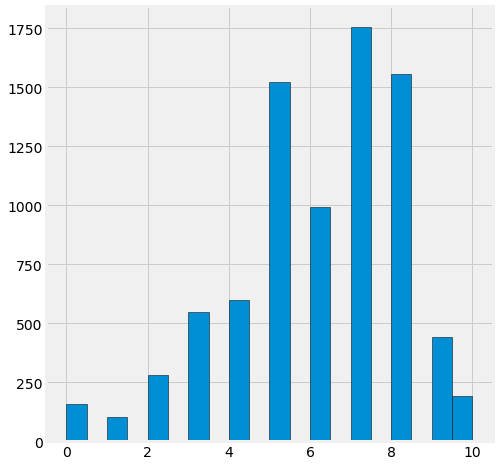

In [3]:
plt.figure(figsize=(8,8))
plt.style.use('fivethirtyeight')
plt.hist(df['pplfair'], bins = 20, edgecolor='k')

In [4]:
# Feature Engineering
# 1. Create Binary age classifier based median age
# 2. Transform Gender into binary
# 3. Create feature of level of not trust and not thinking people are fair
# 4. Create feature of unhappiness
# 5. Combine ppltrst, people fair and people help
df['gndr'] = df['gndr'] - 1
df['ppluntrst'] = 10 - df['ppltrst']
df['pplunfair'] = 10 - df['pplfair']
df['unhappy'] = 10 - df['happy']

In [5]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,ppluntrst,pplunfair,unhappy
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1.0,60.0,1.0,7.0,0.0,2.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1.0,59.0,1.0,5.0,3.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,0.0,24.0,2.0,2.0,2.0,3.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1.0,64.0,1.0,4.0,4.0,0.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1.0,55.0,1.0,4.0,3.0,2.0


In [6]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [7]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



Training set accuracy:
Percent Type I errors: 0.01950354609929078
Percent Type II errors: 0.11824877250409166

Test set accuracy:
Percent Type I errors: 0.08588957055214724
Percent Type II errors: 0.18159509202453988


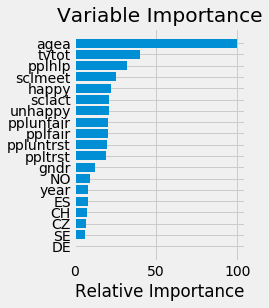

In [8]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()